In [31]:
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 200 µs (started: 2023-02-28 12:59:01 -05:00)


### Imports

In [32]:
# import numpy as np
import matplotlib.pyplot as plt  # required for plotting

import json
import pennylane as qml
import pennylane.numpy as np

import jax
import networkx as nx

from functools import partial

from pennylane.templates import ApproxTimeEvolution

from collections import Counter
import math
import importlib
import pickle
import os


from scipy.spatial.distance import jensenshannon

time: 366 µs (started: 2023-02-28 12:59:01 -05:00)


In [33]:
# check we have the right version of pennylane
# note that pennylane-braket is only compatible with pennylane version 0.27.0
# but we can use the latest version of pennylane for other things
qml.version()

'0.27.0'

time: 1.04 ms (started: 2023-02-28 12:59:01 -05:00)


In [34]:
import utils
utils = importlib.reload(utils)
from utils import *

time: 826 µs (started: 2023-02-28 12:59:01 -05:00)


In [35]:
import sys
# check using the right virtual environment
sys.prefix

'/Users/yan/Repositories/qhack23_rydberg_graph/venv'

time: 1.08 ms (started: 2023-02-28 12:59:01 -05:00)


## Construct hamiltonian demo (simple graph example)

### Graph construction

In [36]:
graphA_nodes = np.array([[0., 0.],[0., 1.], [np.sqrt(3)/2, 0.5], [np.sqrt(3)/2 + 1., 0.5], 
                          [np.sqrt(3) + 1., 0.], [np.sqrt(3) + 1., 1.]])
graphB_nodes = np.array([[0., 0.],[0., 1.], [1., 0.], [1, 1], 
                          [2., 0.], [2., 1.]])                          
graphs_nodes = [graphA_nodes, graphB_nodes] 

# Construct graph specifications from geometric nodes
graphs_pos = []
graphs_geometric = []
for graph_nodes in graphs_nodes:
    pos = dict(zip(range(len(graph_nodes)), graph_nodes))
    geometric = [(i, dict(zip(['pos'], [pos[i]]))) for i in range(len(graph_nodes))]
    graphs_pos.append(pos)
    graphs_geometric.append(geometric)

graphA_nodes_geometric = graphs_geometric[0]
graphA_nodes_pos = graphs_pos[0]
# graphA_nodes_pos = dict(zip(range(len(graphA_nodes)), graphA_nodes))
# graphA_nodes_geometric = [(i, dict(zip(['pos'], [graphA_nodes_pos[i]]))) for i in range(len(graphA_nodes))]
# print(graphA_nodes_geometric)

time: 685 µs (started: 2023-02-28 12:59:01 -05:00)


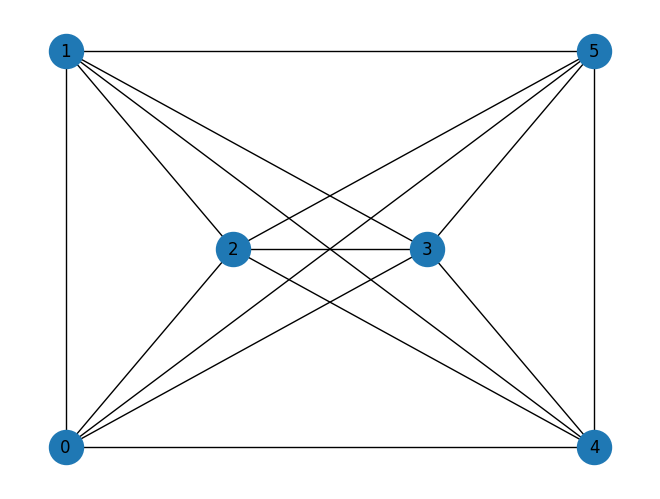

time: 64.3 ms (started: 2023-02-28 12:59:01 -05:00)


In [37]:
#@title Construct graph from geometric nodes
def construct_graph(graph_nodes_geometric, radius=3.1):
    G = nx.Graph()
    G.add_nodes_from(graph_nodes_geometric)
    # nx.geometric_edges(G, radius=1)

    for edge in nx.geometric_edges(G, radius):
        # print(edge)
        G.add_edge(*edge)
    return G
G = construct_graph(graphA_nodes_geometric)
nx.draw(G, with_labels=True, pos=graphA_nodes_pos, node_size=600)    

In [38]:
Gs = [construct_graph(graph_nodes_geometric) for graph_nodes_geometric in graphs_geometric]

time: 477 µs (started: 2023-02-28 12:59:01 -05:00)


In [39]:
def build_hamiltonian(G, omega, delta):
    """
    Builds the approximated Hamiltonian for the given graph.
    Args:
        G (nx.Graph): Graph to build the Hamiltonian for.
        omega (float): Frequency of the oscillator.
        delta (float): Detuning of the oscillator.
    Returns:
        qml.Hamiltonian: Hamiltonian for the given graph.
    """    
    obs = []
    coeffs = []

    V_r = np.sqrt(omega**2 + delta**2)  # rad / sec # Rydberg interaction strength converted from 

    for node in G.nodes(): # construct onsite terms
        coeffs.extend([omega / 2., - delta / 2.])
        obs.extend([qml.PauliX(node), qml.PauliZ(node)])
    for edge in G.edges():
        coeffs.extend([V_r / 4., V_r / 2., V_r / 2.]) 
        obs.extend([qml.PauliZ(edge[0]) @ qml.PauliZ(edge[1]),
                            qml.PauliZ(edge[0]),
                            qml.PauliZ(edge[1])])
    return qml.Hamiltonian(coeffs, obs)


# units for hbar = 1
omega = 1e6  # rad / sec
delta = 0.7 * omega

hamiltonian_rydberg = build_hamiltonian(G, omega, delta)
print(hamiltonian_rydberg)

  (-350000.0) [Z0]
+ (-350000.0) [Z1]
+ (-350000.0) [Z2]
+ (-350000.0) [Z3]
+ (-350000.0) [Z4]
+ (-350000.0) [Z5]
+ (500000.0) [X0]
+ (500000.0) [X1]
+ (500000.0) [X2]
+ (500000.0) [X3]
+ (500000.0) [X4]
+ (500000.0) [X5]
+ (610327.7807866852) [Z0]
+ (610327.7807866852) [Z1]
+ (610327.7807866852) [Z0]
+ (610327.7807866852) [Z2]
+ (610327.7807866852) [Z0]
+ (610327.7807866852) [Z3]
+ (610327.7807866852) [Z0]
+ (610327.7807866852) [Z4]
+ (610327.7807866852) [Z0]
+ (610327.7807866852) [Z5]
+ (610327.7807866852) [Z1]
+ (610327.7807866852) [Z2]
+ (610327.7807866852) [Z1]
+ (610327.7807866852) [Z3]
+ (610327.7807866852) [Z1]
+ (610327.7807866852) [Z4]
+ (610327.7807866852) [Z1]
+ (610327.7807866852) [Z5]
+ (610327.7807866852) [Z2]
+ (610327.7807866852) [Z3]
+ (610327.7807866852) [Z2]
+ (610327.7807866852) [Z4]
+ (610327.7807866852) [Z2]
+ (610327.7807866852) [Z5]
+ (610327.7807866852) [Z3]
+ (610327.7807866852) [Z4]
+ (610327.7807866852) [Z3]
+ (610327.7807866852) [Z5]
+ (610327.7807866852) 

In [40]:
n_wires = len(G.nodes())
wires = range(n_wires)
shots = 10

dev = qml.device('default.qubit', wires=n_wires, shots=shots)


@qml.qnode(dev)
def circuit(time):
    ApproxTimeEvolution(hamiltonian_rydberg, time, 1)
    return qml.counts()

time: 1.27 ms (started: 2023-02-28 12:59:01 -05:00)


In [41]:
counts_results = circuit(1)
print(counts_results)

{'000000': 9, '000001': 1}
time: 18.2 ms (started: 2023-02-28 12:59:01 -05:00)


In [42]:
get_counts_summed_probabilities(counts_results, shots)

array([0.9, 0.1, 0. , 0. , 0. , 0. , 0. ])

time: 1.26 ms (started: 2023-02-28 12:59:01 -05:00)


### run simulations for different time steps

In [43]:
### run the simulation for all graphs

# build hamiltonians for all
Gs = [construct_graph(graph_nodes_geometric) for graph_nodes_geometric in graphs_geometric]
# units for hbar = 1
omega = np.pi * 1e6  # rad / sec
delta = 0.7 * omega
hamiltonians = []
for graph in Gs:  
    hamiltonian_rydberg = build_hamiltonian(graph, omega, delta)
    hamiltonians.append(hamiltonian_rydberg)


time: 2.22 ms (started: 2023-02-28 12:59:01 -05:00)


In [44]:
n_wires = len(Gs[0].nodes())
# n_wires = len(n_nodes)
wires = range(n_wires)
shots = 1000

dev = qml.device('default.qubit', wires=n_wires, shots=shots)


@qml.qnode(dev)
def circuit(time, hamiltonian, n_trotter_steps=100):
    ApproxTimeEvolution(hamiltonian, time, n_trotter_steps)
    return qml.counts()

time: 1.31 ms (started: 2023-02-28 12:59:01 -05:00)


In [45]:
t_range = np.linspace(1e-8, 5.*1e-6, 100)
my_nodesB = [0, 1, 4, 5]
n_prob_list = []
n_expectationB_list = []
n_expectationC_list = []

results = []
# run simulation for different drive durations
for t_max in t_range:
    counts_results_graphs = []
    for hamiltonian in hamiltonians:
        n_trotter_steps = math.floor(t_max * 1e6) * 500 + 1
        # print(n_trotter_steps)
        counts_results = circuit(t_max, hamiltonian, n_trotter_steps)
        # print(counts_results)
        counts_results_graphs.append(counts_results)    
    results.append(counts_results_graphs)

time: 13min 29s (started: 2023-02-28 12:59:01 -05:00)


In [47]:
filename = 'demo_results_pennylane_local.p'

if not os.path.isdir('results_QEK/'):
    os.mkdir('results_QEK/')
with open("results_QEK/"+filename, 'wb') as f:
    f.write(pickle.dumps(results))


time: 11.5 ms (started: 2023-02-28 13:25:58 -05:00)


In [48]:

kernel_counts_fn = partial(outcome_counts, shots=shots)
kernels = []
for t_max, counts_graph in zip(t_range, results): # loop over different drive durations
    # counts_graph = [get_counts(result_graph) for result_graph in results_graph] # get state counts from simulator result
    # counts_graph = [get_counts(result) for result in results] # get state counts from simulator result
    kernel_t = compute_kernel(counts_graph, kernel_counts_fn) # compute kernel matrix
    kernels.append(kernel_t)
kernels = np.stack(kernels)

time: 5.92 ms (started: 2023-02-28 13:25:58 -05:00)


Text(0, 0.5, 'Jensen-Shannon divergence $JS(P1, P2)$')

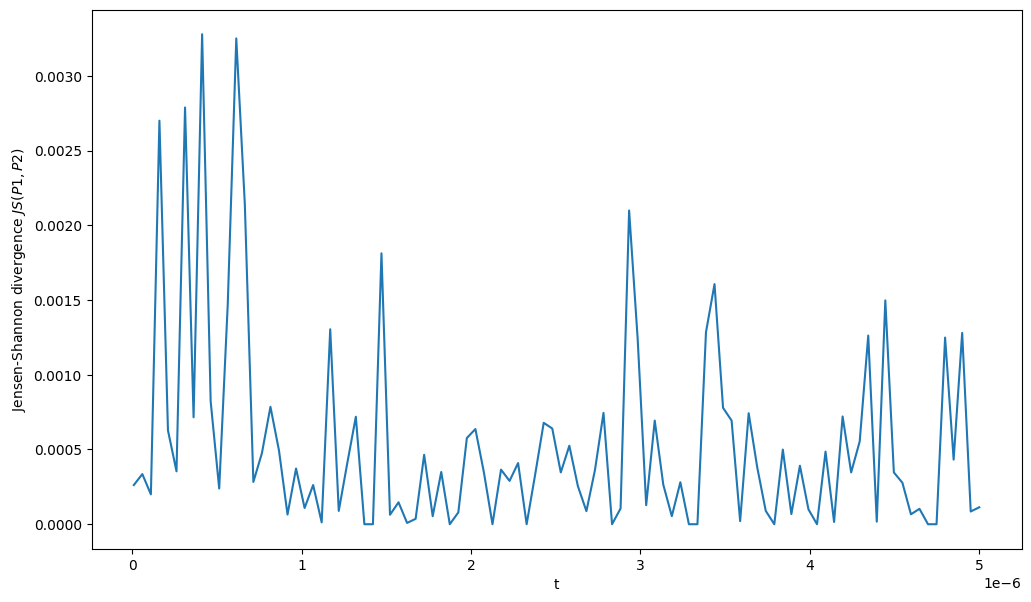

time: 156 ms (started: 2023-02-28 13:25:58 -05:00)


In [49]:
fig, axes = plt.subplots(1, 1, figsize=(12, 7))
axes.plot(t_range, (- np.log(kernels[:, 0, 1]))**2, label='kernel')
axes.set_xlabel('t')
axes.set_ylabel(r'Jensen-Shannon divergence $JS(P1, P2)$')

In [50]:
outcome_fn = partial(get_expectations_nodes, shots=shots, averaged_nodes=my_nodesB)
outcomes = []
for t_max, counts_graph in zip(t_range, results): # loop over different drive durations
    # counts_graph = [get_counts(result_graph) for result_graph in results_graph] # get state counts from simulator result
    outcomes_t = compute_outcomes(counts_graph, outcome_fn) # compute kernel matrix
    # print(outcomes_t.shape)
    outcomes.append(outcomes_t)
outcomes = np.stack(outcomes)    

time: 6.21 ms (started: 2023-02-28 13:25:59 -05:00)


Text(0.5, 0, 'Drive duration [s]')

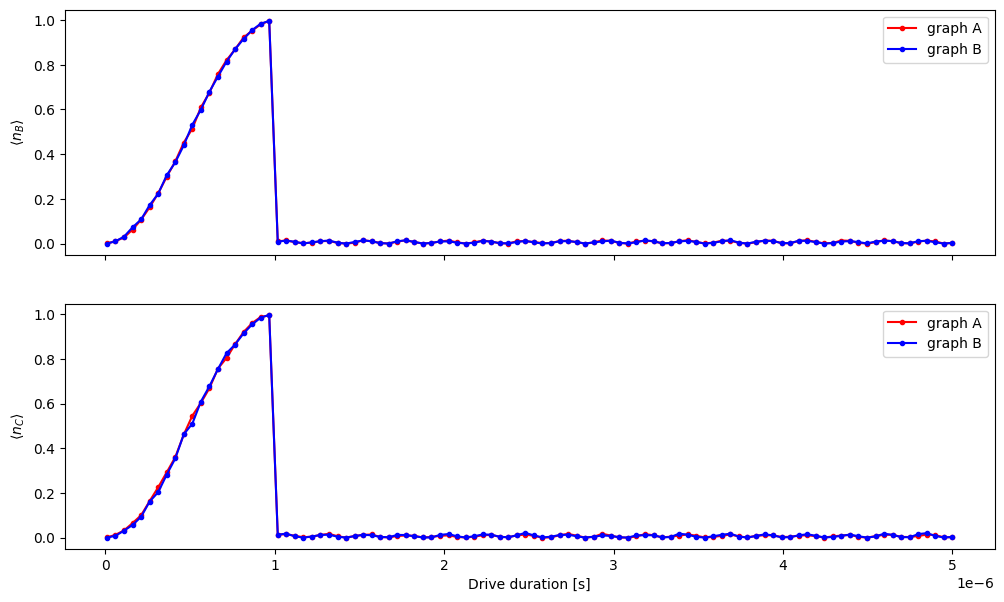

time: 163 ms (started: 2023-02-28 13:25:59 -05:00)


In [51]:
fig, axes = plt.subplots(2, 1, figsize=(12, 7), sharex=True)
y_labels = [r'$\langle n_B \rangle$', r'$\langle n_C \rangle$']
labels = ['B', 'C']
colors = ['r', 'b']
labels_graph = ['A', 'B']
for i, ylabel in enumerate(y_labels):
    ax = axes[i]
    for j in range(2):
        ax.plot(t_range, outcomes[:, j, i], '.-', label=f"graph {labels_graph[j]}", color=colors[j])
    ax.set_ylabel(ylabel)
    ax.legend()

plt.xlabel('Drive duration [s]')
# plt.legend()
# plt.ylabel(r'$\langle n \rangle$')

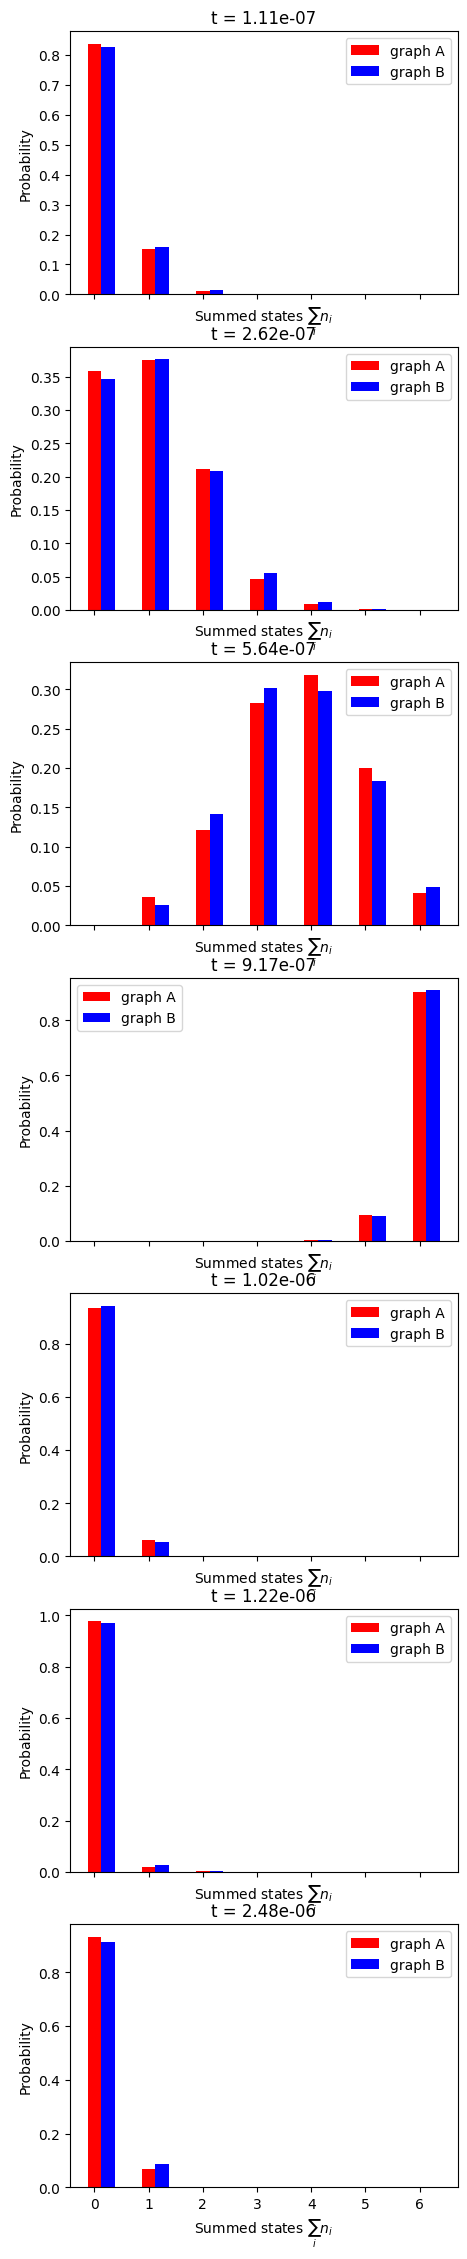

time: 597 ms (started: 2023-02-28 13:25:59 -05:00)


In [52]:
t_list = [0.1e-6, 0.25e-6, 0.57e-6, 0.924e-6, 1.04e-6, 1.2e-6, 2.5e-6]
barWidth = 0.25
br1 = np.arange(len(graphA_nodes)+1)
br2 = [x + barWidth for x in br1]
bars = [br1, br2]
colors = ['r', 'b']
labels = ['graph A', 'graph B']
# plot the probability distribution for different drive durations as a function of summed states
fig, axes = plt.subplots(len(t_list), 1, figsize=(5, 4 * len(t_list)), sharex=True)
for t, ax in zip(t_list, axes):
    # idx = np.where(t_range == t)[0][0] # get index of t
    idx = np.argmin(np.abs(t_range - t))
    probabilities = []
    
    for i in range(2):
        counts_graph = results[idx][i]
        p = get_counts_summed_probabilities(counts_graph, shots=shots)
        probabilities.append(p)
        # print(p)

        ax.bar(bars[i], p, label=labels[i], width=barWidth, color=colors[i])
        # ax.set_ylim(0, 1)
        ax.set_ylabel("Probability")
        ax.set_xlabel(r"Summed states $\sum_i n_i$")
        ax.legend()
        ax.set_title('t = {:.2e}'.format(t_range[idx]))
    # ax.set_title('t = {:.2e}'.format(t))




### run simulations for different time steps on SV1

In [53]:
### run the simulation for all graphs

# build hamiltonians for all
Gs = [construct_graph(graph_nodes_geometric) for graph_nodes_geometric in graphs_geometric]
# units for hbar = 1
omega = np.pi * 1e6  # rad / sec
delta = 0.7 * omega
hamiltonians = []
for graph in Gs:  
    hamiltonian_rydberg = build_hamiltonian(graph, omega, delta)
    hamiltonians.append(hamiltonian_rydberg)


time: 2.05 ms (started: 2023-02-28 13:25:59 -05:00)


In [54]:
my_bucket = "amazon-braket-us-west-1-880812766447"  # the name of the bucket, keep the 'amazon-braket-' prefix and then include the bucket name
my_prefix = "QEK_sv1_demo"  # the name of the folder in the bucket
s3_folder = (my_bucket, my_prefix)

device_arn = "arn:aws:braket:::device/quantum-simulator/amazon/sv1"

time: 253 µs (started: 2023-02-28 13:26:00 -05:00)


In [55]:
n_wires = len(Gs[0].nodes())
# n_wires = len(n_nodes)
wires = range(n_wires)
shots = 1000

# dev = qml.device('default.qubit', wires=n_wires, shots=shots)
dev_remote = qml.device(
    "braket.aws.qubit",
    device_arn=device_arn,
    wires=n_wires,
    s3_destination_folder=s3_folder,
    shots=shots,
    parallel=True,
)


@qml.qnode(dev_remote)
def circuit(time, hamiltonian, n_trotter_steps=100):
    ApproxTimeEvolution(hamiltonian, time, n_trotter_steps)
    return qml.probs(wires=wires)

time: 1.28 s (started: 2023-02-28 13:26:00 -05:00)


In [56]:
my_probs = circuit(1e-6, hamiltonians[0], 5)

time: 4.2 s (started: 2023-02-28 13:26:01 -05:00)


In [57]:
t_range = np.linspace(1e-8, 5.*1e-6, 100)
my_nodesB = [0, 1, 4, 5]
n_prob_list = []
n_expectationB_list = []
n_expectationC_list = []

results = []
# run simulation for different drive durations
for t_max in t_range:
    counts_results_graphs = []
    for hamiltonian in hamiltonians:
        n_trotter_steps = math.floor(t_max * 1e6) * 500 + 1
        # print(n_trotter_steps)
        counts_results = circuit(t_max, hamiltonian, n_trotter_steps)
        # print(counts_results)
        counts_results_graphs.append(counts_results)    
    results.append(counts_results_graphs)

ClientError: An error occurred (InternalServerErrorException) when calling the CreateQuantumTask operation (reached max retries: 4): Endpoint request timed out

time: 44min 7s (started: 2023-02-28 13:26:05 -05:00)


In [ ]:
filename = 'demo_results_pennylane_sv1.p'

if not os.path.isdir('results_QEK/'):
    os.mkdir('results_QEK/')
with open("results_QEK/"+filename, 'wb') as f:
    f.write(pickle.dumps(results))


In [ ]:
new_results = [[_convert_to_counts(result_graph, n_wires) for result_graph in results_graph]for results_graph in results]

In [ ]:
new_results[0][0]

In [ ]:

kernel_counts_fn = partial(outcome_counts, shots=shots)
kernels = []
for t_max, counts_graph in zip(t_range, new_results): # loop over different drive durations
    # counts_graph = [get_counts(result_graph) for result_graph in results_graph] # get state counts from simulator result
    # counts_graph = [get_counts(result) for result in results] # get state counts from simulator result
    kernel_t = compute_kernel(counts_graph, kernel_counts_fn) # compute kernel matrix
    kernels.append(kernel_t)
kernels = np.stack(kernels)

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(12, 7))
axes.plot(t_range, (- np.log(kernels[:, 0, 1]))**2, label='kernel')
axes.set_xlabel('t')
axes.set_ylabel(r'Jensen-Shannon divergence $JS(P1, P2)$')

In [ ]:
outcome_fn = partial(get_expectations_nodes, shots=shots, averaged_nodes=my_nodesB)
outcomes = []
for t_max, counts_graph in zip(t_range, new_results): # loop over different drive durations
    # counts_graph = [get_counts(result_graph) for result_graph in results_graph] # get state counts from simulator result
    outcomes_t = compute_outcomes(counts_graph, outcome_fn) # compute kernel matrix
    # print(outcomes_t.shape)
    outcomes.append(outcomes_t)
outcomes = np.stack(outcomes)    

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(12, 7), sharex=True)
y_labels = [r'$\langle n_B \rangle$', r'$\langle n_C \rangle$']
labels = ['B', 'C']
colors = ['r', 'b']
labels_graph = ['A', 'B']
for i, ylabel in enumerate(y_labels):
    ax = axes[i]
    for j in range(2):
        ax.plot(t_range, outcomes[:, j, i], '.-', label=f"graph {labels_graph[j]}", color=colors[j])
    ax.set_ylabel(ylabel)
    ax.legend()

plt.xlabel('Drive duration [s]')
# plt.legend()
# plt.ylabel(r'$\langle n \rangle$')

In [ ]:
t_list = [0.1e-6, 0.25e-6, 0.57e-6, 0.924e-6, 1.04e-6, 1.2e-6, 2.5e-6]
barWidth = 0.25
br1 = np.arange(len(graphA_nodes)+1)
br2 = [x + barWidth for x in br1]
bars = [br1, br2]
colors = ['r', 'b']
labels = ['graph A', 'graph B']
# plot the probability distribution for different drive durations as a function of summed states
fig, axes = plt.subplots(len(t_list), 1, figsize=(5, 4 * len(t_list)), sharex=True)
for t, ax in zip(t_list, axes):
    # idx = np.where(t_range == t)[0][0] # get index of t
    idx = np.argmin(np.abs(t_range - t))
    probabilities = []
    
    for i in range(2):
        counts_graph = new_results[idx][i]
        p = get_counts_summed_probabilities(counts_graph, shots=shots)
        probabilities.append(p)
        # print(p)

        ax.bar(bars[i], p, label=labels[i], width=barWidth, color=colors[i])
        # ax.set_ylim(0, 1)
        ax.set_ylabel("Probability")
        ax.set_xlabel(r"Summed states $\sum_i n_i$")
        ax.legend()
        ax.set_title('t = {:.2e}'.format(t_range[idx]))
    # ax.set_title('t = {:.2e}'.format(t))


